In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

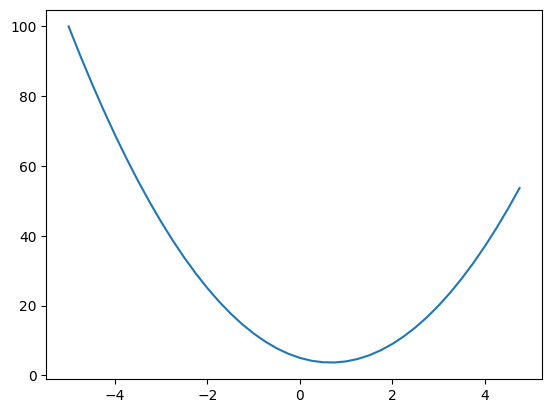

In [8]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

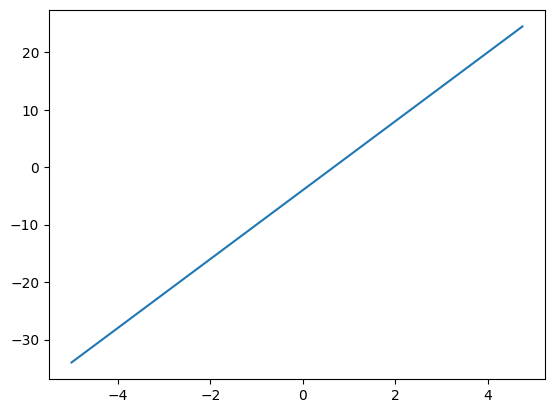

In [17]:
h = 0.0001
x = 3.0
(f(x + h) - f(x)) / h

def df(f):
    return lambda x: (f(x + h) - f(x - h)) / (2 * h)

ys = df(f)(xs)
plt.plot(xs, ys)

In [20]:
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print((d2 - d1) / h)

0.9999999999976694


In [44]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), '-')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    
    def __pow__(self, x):
        return Value(self.data ** x, (self, other), '**')
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b
e.label = 'e'

d = e + c
d.label = 'd'

f = Value(-2.0, label='f')

L = d * f
L.label = 'L'

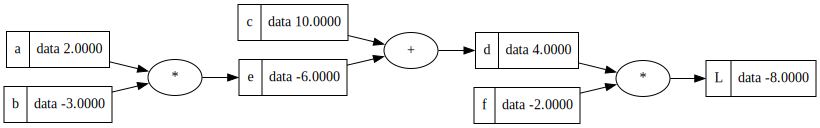

In [46]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
        
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
                 
    return dot
                 
draw_dot(L)
